## Step 1: Import Required Libraries

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Step 2: Load and Inspect the Dataset

In [20]:
# Load the full energy dataset, parsing dates and setting Datetime as index.
df_energy = pd.read_csv("powerconsumption.csv", parse_dates=["Datetime"], index_col="Datetime")
df_energy = df_energy.resample("H").mean()  # Resample to hourly mean

# Display first few rows to inspect the data
print(df_energy.head())

                     Temperature   Humidity  WindSpeed  GeneralDiffuseFlows  \
Datetime                                                                      
2017-01-01 00:00:00     6.196833  75.066667   0.081833             0.063500   
2017-01-01 01:00:00     5.548833  77.583333   0.082000             0.056833   
2017-01-01 02:00:00     5.054333  78.933333   0.082333             0.063000   
2017-01-01 03:00:00     5.004333  77.083333   0.082833             0.059833   
2017-01-01 04:00:00     5.097667  74.050000   0.082333             0.058000   

                     DiffuseFlows  PowerConsumption_Zone1  \
Datetime                                                    
2017-01-01 00:00:00      0.098833            29197.974683   
2017-01-01 01:00:00      0.112500            24657.215190   
2017-01-01 02:00:00      0.129167            22083.037973   
2017-01-01 03:00:00      0.141000            20811.139240   
2017-01-01 04:00:00      0.122833            20475.949367   

                  

## Step 3: Exploratory Visualisation

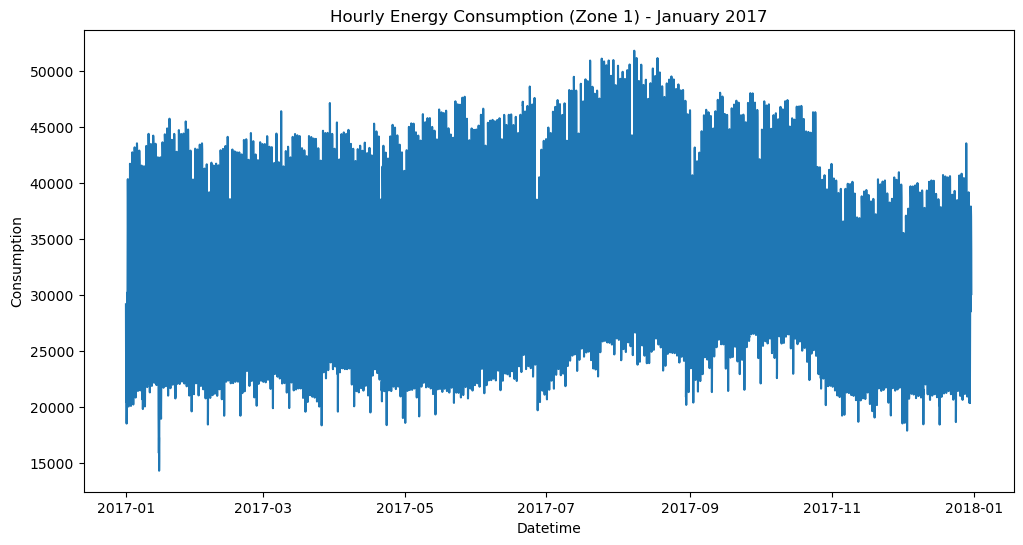

In [21]:
# Plot the hourly consumption for Zone1 to visualise any anomalies or trends
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_energy.index, y="PowerConsumption_Zone1", data=df_energy)
plt.title("Hourly Energy Consumption (Zone 1) - January 2017")
plt.xlabel("Datetime")
plt.ylabel("Consumption")
plt.show()

## Step 4: Linear Regression Model – Data Preparation & Forecast

Linear Regression MAE: **1016.81**
Linear Regression MAPE: **0.0327**


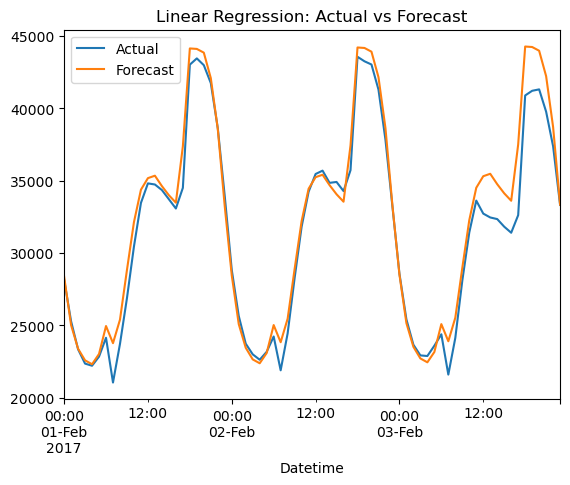

In [22]:
# Load only the required columns for regression analysis
df_lr = pd.read_csv("powerconsumption.csv", usecols=["Datetime", "PowerConsumption_Zone1"], parse_dates=["Datetime"])

# Resample to hourly data and reset index
df_lr = df_lr.resample("H", on="Datetime").mean().reset_index()

# Rename column for clarity: use 'zone1_usage' instead of 'PowerConsumption_Zone1'
df_lr.rename(columns={"PowerConsumption_Zone1": "zone1_usage"}, inplace=True)

# Feature engineering: extract hour (categorical) and create a time-based trend
df_lr["hour_cat"] = df_lr["Datetime"].dt.hour.astype("string")
df_lr["time_trend"] = np.arange(len(df_lr))

# Convert the hour column into dummy variables (drop first category)
df_lr_dummy = pd.get_dummies(df_lr.set_index("Datetime"), columns=["hour_cat"], drop_first=True, dtype="int")

# Split the data: training period is January, testing period is Feb 1-3 (72 hours)
train_lr = df_lr_dummy.loc[:'2017-01-31']
test_lr = df_lr_dummy.loc['2017-02-01':'2017-02-03']

# Prepare predictors and target for OLS
X_train_lr = sm.add_constant(train_lr.drop("zone1_usage", axis=1))
y_train_lr = train_lr["zone1_usage"]

# Fit the linear regression model using OLS
ols_model = sm.OLS(y_train_lr, X_train_lr).fit()

# Make predictions on the test set
X_test_lr = sm.add_constant(test_lr.drop("zone1_usage", axis=1))
y_test_lr = test_lr["zone1_usage"]
lr_forecast = ols_model.predict(X_test_lr)

# Evaluate performance metrics
mae_lr = mean_absolute_error(y_test_lr, lr_forecast)
mape_lr = mean_absolute_percentage_error(y_test_lr, lr_forecast)

# Print metrics with markdown bold formatting in the output string
print("Linear Regression MAE: **{:.2f}**".format(mae_lr))
print("Linear Regression MAPE: **{:.4f}**".format(mape_lr))

# Plot the actual vs forecasted values
df_lr_results = pd.DataFrame({"Actual": y_test_lr, "Forecast": lr_forecast})
df_lr_results.plot(title="Linear Regression: Actual vs Forecast")
plt.show()

## Step 5: Facebook Prophet Model – Data Preparation & Forecast

16:14:17 - cmdstanpy - INFO - Chain [1] start processing
16:14:17 - cmdstanpy - INFO - Chain [1] done processing


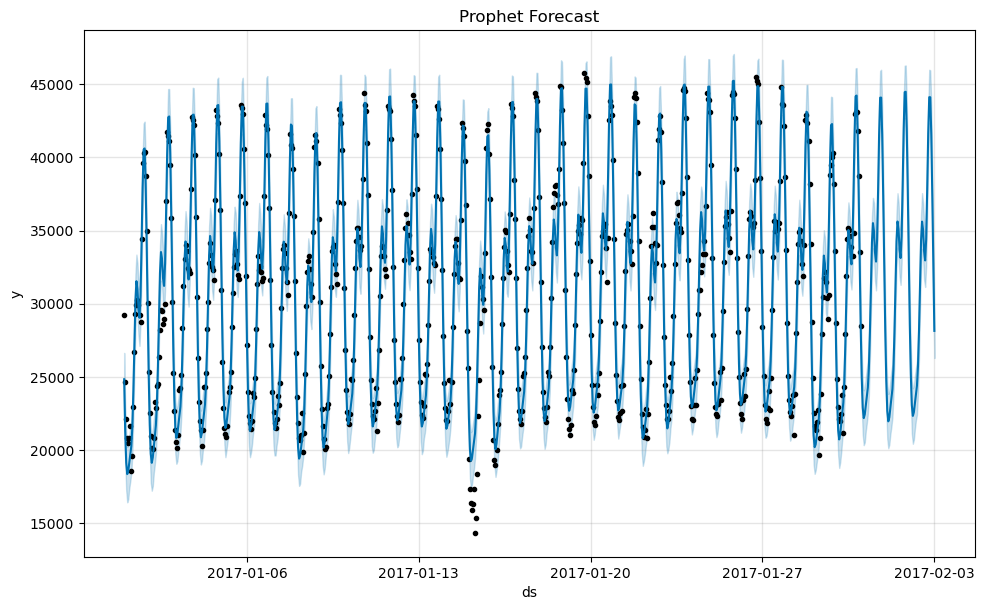

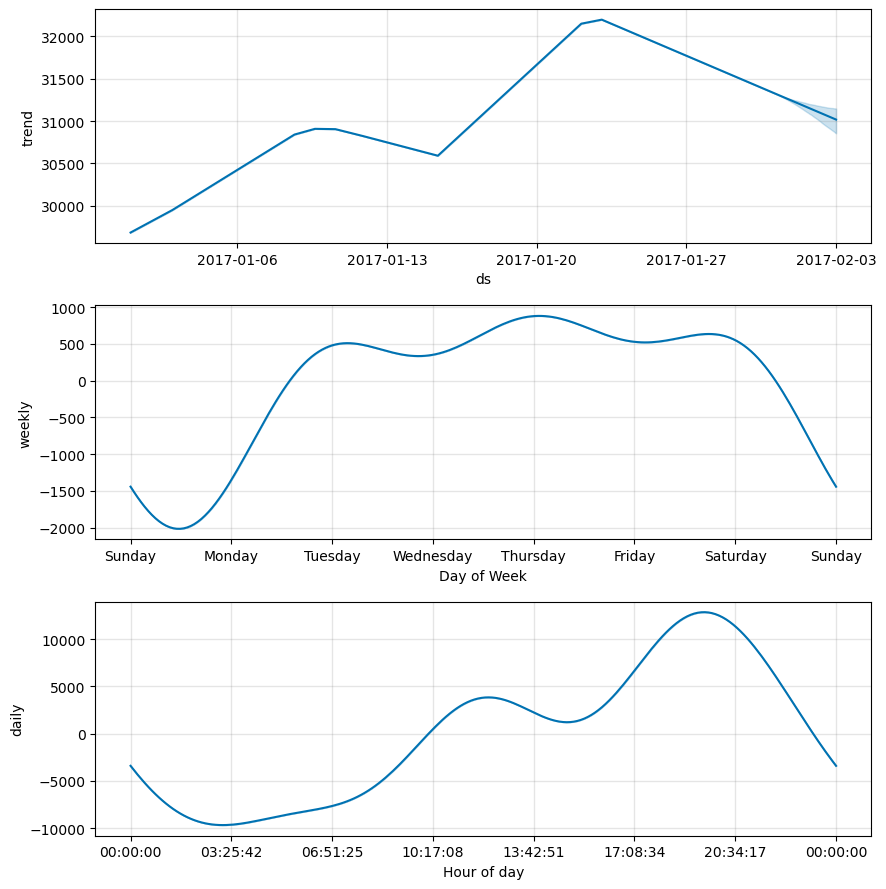

Prophet MAE: 857.2251371512224
Prophet MAPE: 0.02826578546226317


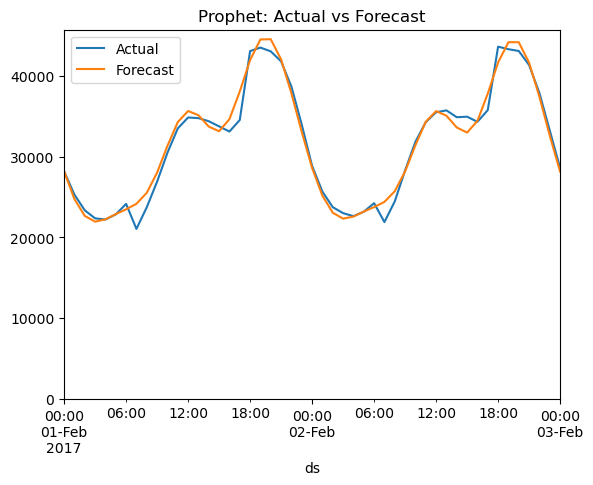

In [23]:
# Prepare data for Prophet by renaming columns to 'ds' (datetime) and 'y' (target)
df_prophet = df_lr[["Datetime", "zone1_usage"]].rename(columns={"Datetime": "ds", "zone1_usage": "y"})

# Define training and testing periods for Prophet
train_prophet = df_prophet[df_prophet["ds"] <= "2017-01-31"]
test_prophet = df_prophet[(df_prophet["ds"] >= "2017-02-01") & (df_prophet["ds"] <= "2017-02-03")]

# Initialise and train the Prophet model
prophet_model = Prophet()
prophet_model.fit(train_prophet)

# Create a future dataframe for the next 72 hours (3 days)
future_dates = prophet_model.make_future_dataframe(periods=72, freq="H")
prophet_forecast = prophet_model.predict(future_dates)

# Plot the forecast and its components
prophet_model.plot(prophet_forecast)
plt.title("Prophet Forecast")
plt.show()

prophet_model.plot_components(prophet_forecast)
plt.show()

# Extract the predicted values corresponding to the test period
forecast_prophet = prophet_forecast.set_index("ds").loc["2017-02-01":"2017-02-03"]["yhat"]

# Evaluate performance of Prophet predictions
prophet_mae = mean_absolute_error(test_prophet.set_index("ds")["y"], forecast_prophet)
prophet_mape = mean_absolute_percentage_error(test_prophet.set_index("ds")["y"], forecast_prophet)

print("Prophet MAE:", prophet_mae)
print("Prophet MAPE:", prophet_mape)

# Plot actual values vs Prophet forecast
df_prophet_results = pd.DataFrame({
    "Actual": test_prophet.set_index("ds")["y"],
    "Forecast": forecast_prophet
})
df_prophet_results.plot(title="Prophet: Actual vs Forecast", ylim=(0, None))
plt.show()


# Alternative Approaches and Improvements
## Step 2: Load and Prepare Data

In [24]:
# Load the dataset, parse dates, and resample to hourly averages
data = pd.read_csv("powerconsumption.csv", parse_dates=["Datetime"], index_col="Datetime")
data = data.resample("H").mean()

# Inspect the first few rows
print(data.head())


                     Temperature   Humidity  WindSpeed  GeneralDiffuseFlows  \
Datetime                                                                      
2017-01-01 00:00:00     6.196833  75.066667   0.081833             0.063500   
2017-01-01 01:00:00     5.548833  77.583333   0.082000             0.056833   
2017-01-01 02:00:00     5.054333  78.933333   0.082333             0.063000   
2017-01-01 03:00:00     5.004333  77.083333   0.082833             0.059833   
2017-01-01 04:00:00     5.097667  74.050000   0.082333             0.058000   

                     DiffuseFlows  PowerConsumption_Zone1  \
Datetime                                                    
2017-01-01 00:00:00      0.098833            29197.974683   
2017-01-01 01:00:00      0.112500            24657.215190   
2017-01-01 02:00:00      0.129167            22083.037973   
2017-01-01 03:00:00      0.141000            20811.139240   
2017-01-01 04:00:00      0.122833            20475.949367   

                  

## Step 3: Train-Test Split and Feature Selection

In [25]:
# Define training period (January 2017) and testing period (first 3 days of February 2017)
train = data.loc['2017-01-01':'2017-01-31']
test = data.loc['2017-02-01':'2017-02-03']

# Define target variable: electricity consumption in Zone 1
y_train = train['PowerConsumption_Zone1']
y_test = test['PowerConsumption_Zone1']

# Define exogenous variables: Temperature, Humidity, WindSpeed
exog_train = train[['Temperature', 'Humidity', 'WindSpeed']]
exog_test = test[['Temperature', 'Humidity', 'WindSpeed']]


## Step 4: ARIMAX Model with Exogenous Variables

In [34]:
# Fit a SARIMAX model (ARIMAX) with orders set to capture daily seasonality (seasonal period = 24)
arimax_model = SARIMAX(y_train, exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
arimax_results = arimax_model.fit(disp=False)
print(arimax_results.summary())

# Forecast using ARIMAX over the test period using the corresponding exogenous variables
forecast_arimax = arimax_results.predict(start=test.index[0], end=test.index[-1], exog=exog_test)

# Evaluation Metrics for ARIMAX
arimax_mae = mean_absolute_error(y_test, forecast_arimax)
arimax_mape = mean_absolute_percentage_error(y_test, forecast_arimax)
print("ARIMAX MAE: **{:.2f}**".format(arimax_mae))
print("ARIMAX MAPE: **{:.4f}**".format(arimax_mape))


                                     SARIMAX Results                                      
Dep. Variable:             PowerConsumption_Zone1   No. Observations:                  744
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood               -5738.621
Date:                            Fri, 14 Mar 2025   AIC                          11493.242
Time:                                    16:18:25   BIC                          11529.865
Sample:                                01-01-2017   HQIC                         11507.382
                                     - 01-31-2017                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature   -12.3727     45.660     -0.271      0.786    -101.865      77.119
Humidity       19.1553      7.21

## Step 5: Exponential Smoothing (Holt-Winters) Model

In [30]:
# Fit an Exponential Smoothing model using additive trend and seasonality (seasonal period = 24)
hw_model = ExponentialSmoothing(y_train, trend="add", seasonal="add", seasonal_periods=24)
hw_results = hw_model.fit()
forecast_hw = hw_results.forecast(len(y_test))

# Evaluation Metrics for Exponential Smoothing
hw_mae = mean_absolute_error(y_test, forecast_hw)
hw_mape = mean_absolute_percentage_error(y_test, forecast_hw)
print("Exponential Smoothing MAE: **{:.2f}**".format(hw_mae))
print("Exponential Smoothing MAPE: **{:.4f}**".format(hw_mape))



Exponential Smoothing MAE: **1430.25**
Exponential Smoothing MAPE: **0.0459**


## Step 6: Forecast Comparison Plot

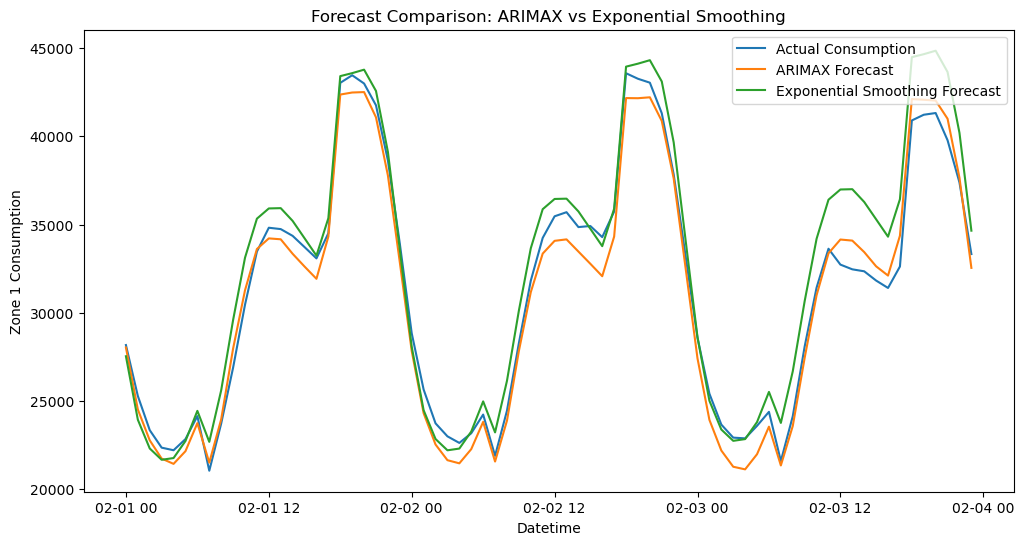

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Consumption")
plt.plot(y_test.index, forecast_arimax, label="ARIMAX Forecast")
plt.plot(y_test.index, forecast_hw, label="Exponential Smoothing Forecast")
plt.xlabel("Datetime")
plt.ylabel("Zone 1 Consumption")
plt.title("Forecast Comparison: ARIMAX vs Exponential Smoothing")
plt.legend()
plt.show()